# CKP8366 - TÓPICOS AVANÇADOS - APRENDIZAGEM DE MÁQUINA PROBABILÍSTICA

<img  src="https://img.shields.io/badge/UFC_CKP8366-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" />

In [8]:
import numpy as np
from scipy.stats import norm, gamma

import json
import itertools
import matplotlib.pyplot as plt

## Probabilistic Principal Components Analysis (PPCA)

In [71]:
class ProbabilisticPCA:
  #
  def __init__(self, L, epochs=50, seed=42):
    self.L = L
    self.epochs = epochs
    self.seed = seed
    self.code = f'L{L:02}E{epochs}S{seed}'
    
    self.mu = None
    self.W = None
    self.Z = None
    self.sigma2 = None
    self.likelihoods = None
   
  # 
  def fit(self, X, verbose=False):
    np.random.seed(self.seed)
    
    #
    N, D = X.shape
    L = min(max(1, self.L), D) # Safety
    
    # Step 1.1
    mu = np.mean(X, axis=0)
    W = np.random.normal(0, 0.1, size=(D, L))
    sigma2 = 1.0
    
    #
    likelihoods = np.zeros(self.epochs)
    
    # Epochs
    for e in range(self.epochs):
      # "Progress bar"
      if verbose:
        print(f'[ {"#" * (e + 1)}{"-" * (self.epochs - e - 1)} ]: {e + 1}/{self.epochs}', end="\r")
        
      # Step E / Step 2.1
      Minv = np.linalg.inv(W.T @ W + sigma2 * np.eye(L))
      MinvWT = Minv @ W.T

      Ez = np.zeros((N, L))
      EzzT = np.zeros((N, L, L))

      for i in range(N):
          diff = X[i] - mu
          Ez[i] = MinvWT @ diff
          EzzT[i] = sigma2 * Minv + np.outer(Ez[i], Ez[i])
 
      # Step M / Step 2.2
      W = np.zeros((D, L))
      for i in range(N):
          diff = X[i] - mu
          W += np.outer(diff, Ez[i])

      W = W @ np.linalg.inv(np.sum(EzzT, axis=0))
      
      #
      sigma2_ = 0
      for i in range(N):
          diff = X[i] - mu
          sigma2_ += np.linalg.norm(diff)**2 - 2 * np.dot(Ez[i], W.T @ diff) + np.trace(EzzT[i] @ W.T @ W)

      sigma2 = (1 / (N * D)) * sigma2_
      
      # Likelihood      
      try:
          Sigma = W @ W.T + sigma2 * np.eye(D)
          SigmaInv = np.linalg.inv(Sigma)
          
          chocho = np.linalg.cholesky(Sigma)
          logdet = 2 * np.sum(np.log(np.diag(chocho)))
          last = np.sum(np.einsum('ni,ij,nj->n', X - mu, SigmaInv, X - mu))
          
          likelihoods[e] = (-0.5 * N * D * np.log(2 * np.pi) - 0.5 * N * logdet - 0.5 * last)
      except np.linalg.LinAlgError:
          likelihoods[e] = -np.inf
          break # Deu ruim: Sigma não determinado

    # Safety
    if verbose:
      print('Fim', end='\r')
        
    self.mu = mu
    self.W = W
    self.sigma2 = sigma2
    self.Z = Ez
    self.likelihoods = likelihoods
    
  # 
  def get_reconstructions(self, size=1):
    return self.__predict(self.Z[:size])
  
  #
  def get_samples(self, size=1):
    Z_ = np.random.normal(size=(size, self.L))
    return self.__predict(Z_)
  
  #
  def __predict(self, Z):
    return np.dot(Z, self.W.T) + self.mu

  #
  def save(self, filename):
    data = {
      'L': self.L,
      'epochs': self.epochs,
      'seed': self.seed,
      
      'mu': self.mu.tolist() if self.mu is not None else None,
      'W': self.W.tolist() if self.W is not None else None,
      'Z': self.Z.tolist() if self.Z is not None else None,
      'likelihoods': self.likelihoods.tolist() if self.likelihoods is not None else None,
      'sigma2': self.sigma2,
    }
    
    with open(filename, 'w') as file:
      json.dump(data, file, indent=2)
     
  # 
  @classmethod
  def load(cls, filename):
    with open(filename, 'r') as file:
      data = json.load(file)
      
      instance = cls(L=data['L'], epochs=data['epochs'], seed=data['seed'])
      instance.mu = np.array(data['mu']) if data['mu'] is not None else None
      instance.W = np.array(data['W']) if data['W'] is not None else None
      instance.Z = np.array(data['Z']) if data['Z'] is not None else None
      instance.likelihoods = np.array(data['likelihoods']) if data['likelihoods'] is not None else None
      instance.sigma2 = np.array(data['sigma2'])
      
      return instance
    
  #
  def __str__(self):
      return f"ProbabilisticPCA: (L → {self.L})(Epochs → {self.epochs})"

#### Carregamento dos dados

In [45]:
# Data
X = np.genfromtxt('./files/mnist_5.csv', delimiter=',')
X.shape

(6313, 784)

#### Training

In [46]:
def run(X, Ls, epochs=[20], seed=42, verbose=False, path=None):
  models = []
  
  for L in Ls:
    for E in epochs:
      ppca = ProbabilisticPCA(L=L, epochs=E, seed=seed)
      
      if verbose:
        print(ppca)
        
      ppca.fit(X, verbose=verbose)
      models.append(ppca)
      
      if path:
        filename = f'{path}L{ppca.L}E{ppca.epochs}S{ppca.seed}.json'
        ppca.save(filename)
        
        if verbose:
          print("Saved: ", filename)
    
  return models

In [47]:
%time models = run(X, Ls=[2, 5, 10, 20], epochs=[50, 100], verbose=True, path='./files/saves/')

ProbabilisticPCA: (L → 2)(Epochs → 50)
Saved:  ./files/saves/L2E50S42.json################# ]: 50/50
ProbabilisticPCA: (L → 2)(Epochs → 100)
Saved:  ./files/saves/L2E100S42.json################################################################## ]: 100/100
ProbabilisticPCA: (L → 5)(Epochs → 50)
Saved:  ./files/saves/L5E50S42.json################# ]: 50/50
ProbabilisticPCA: (L → 5)(Epochs → 100)
Saved:  ./files/saves/L5E100S42.json################################################################## ]: 100/100
ProbabilisticPCA: (L → 10)(Epochs → 50)
Saved:  ./files/saves/L10E50S42.json################ ]: 50/50
ProbabilisticPCA: (L → 10)(Epochs → 100)
Saved:  ./files/saves/L10E100S42.json################################################################# ]: 100/100
ProbabilisticPCA: (L → 20)(Epochs → 50)
Saved:  ./files/saves/L20E50S42.json################ ]: 50/50
ProbabilisticPCA: (L → 20)(Epochs → 100)
Saved:  ./files/saves/L20E100S42.json#####################################################

#### Loading models

In case you closed your notebook or you're restarting work after pausing training the `models` variable won't be declared. In this case this notebook will load your saved models using the `Ls` as model references. Otherwise use `force_load` to force loading saved models.

In [72]:
# Force
force_load = True

# Just in case
if 'models' not in globals() or force_load:
  # Config
  L = [2, 5, 10, 20]
  E = [20, 50 ,100]

  path = './files/saves/'
  
  # Loading
  models = [ProbabilisticPCA.load(f'{path}L{l}E{e}S42.json') for l, e in itertools.product(L, E)]
  
  print('Loaded')
  for model in models:
    print(' -', model.code)

Loaded
 - L02E20S42
 - L02E50S42
 - L02E100S42
 - L05E20S42
 - L05E50S42
 - L05E100S42
 - L10E20S42
 - L10E50S42
 - L10E100S42
 - L20E20S42
 - L20E50S42
 - L20E100S42


#### Plotting stuff

In [56]:
#
def plot_digits(data, title, cols=7):
  rows = max(data.shape[0] // cols + 1, 1)
  fig, axs = plt.subplots(rows, cols)
  axs = axs.flatten()

  for i in range(len(data)):
    axs[i].imshow(data[i].reshape(28, 28), cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
  
  # Just in case 
  for i in range(len(data), rows * cols):
    axs[i].set_visible(False)
    
  fig.suptitle(title, fontsize=18)
  fig.tight_layout()

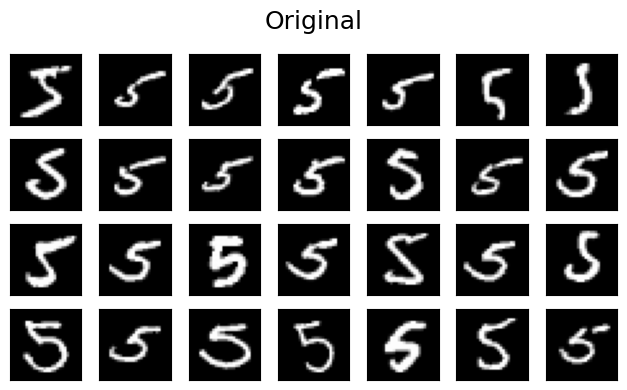

In [ ]:
#
plot_digits(X[:28], 'Original')

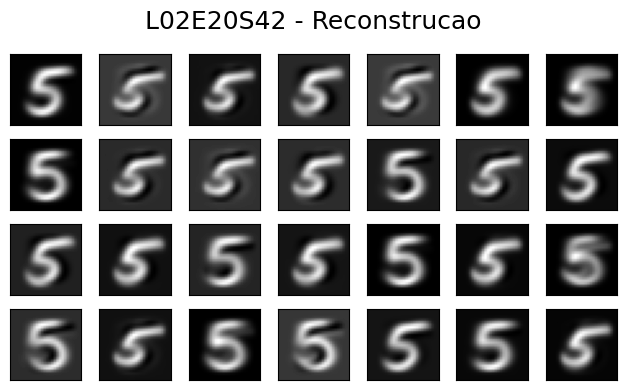

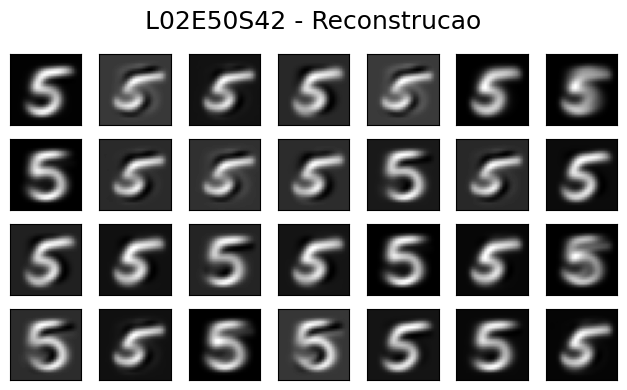

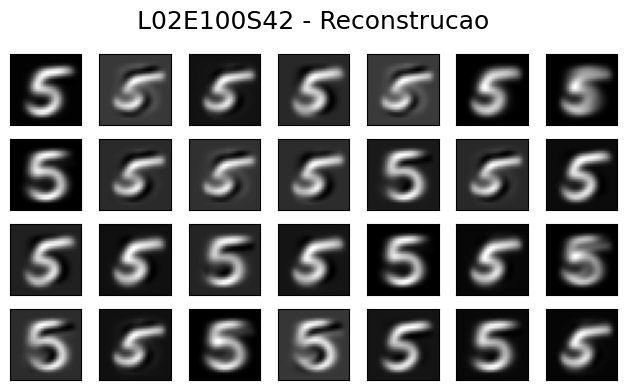

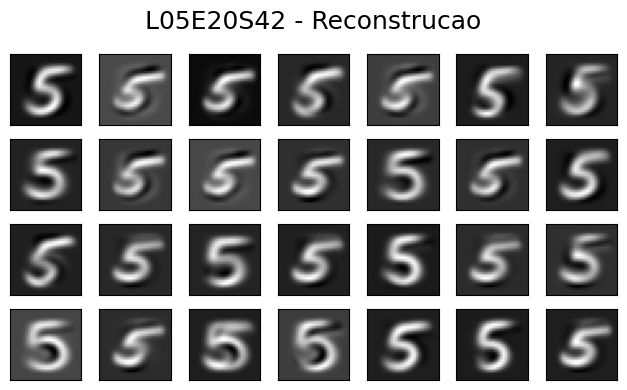

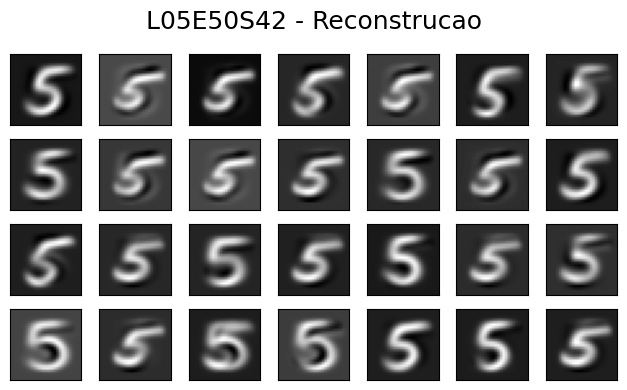

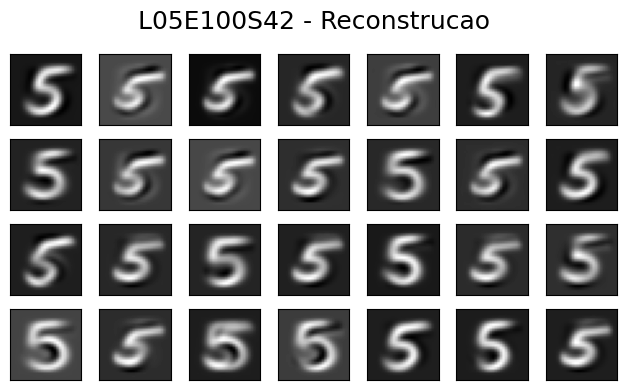

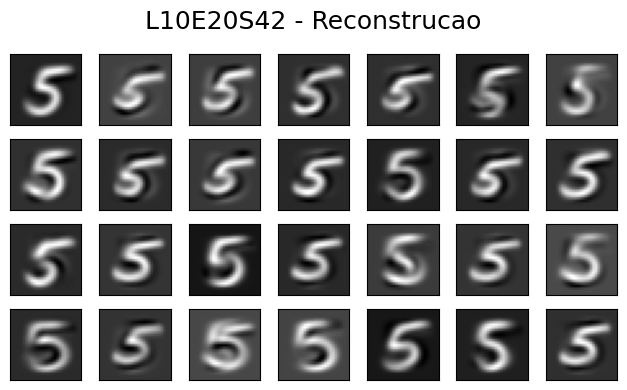

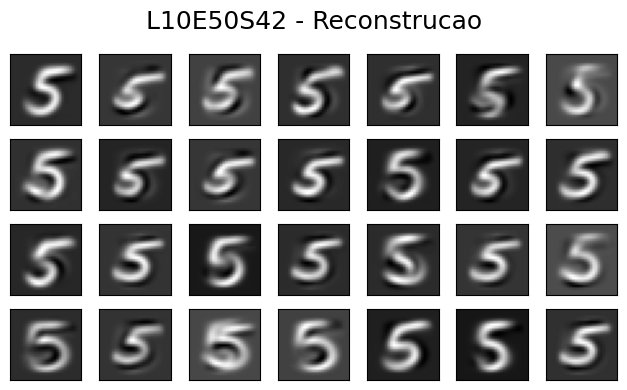

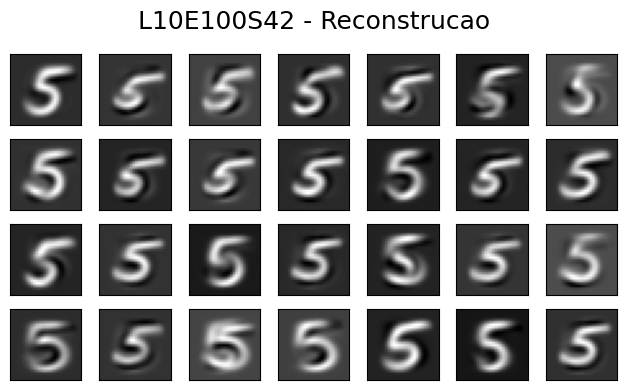

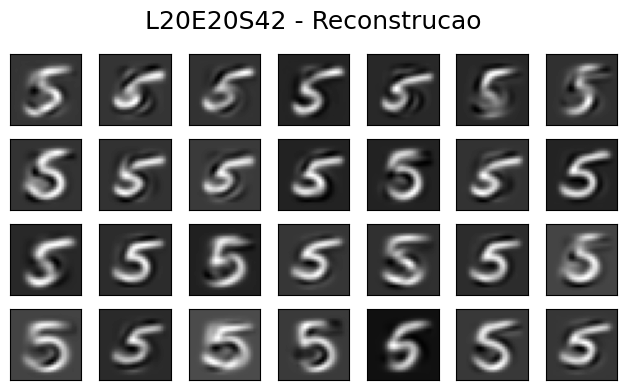

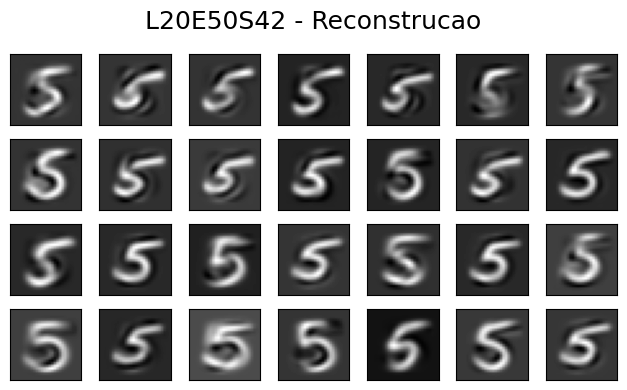

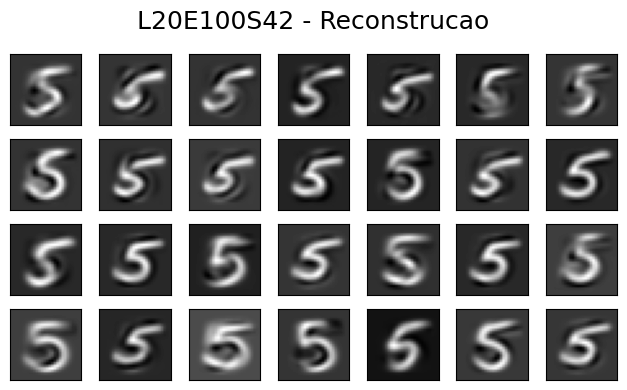

In [73]:
# Reconstrucao
for model in models:
  plot_digits(model.get_reconstructions(size=28), f'{model.code} - Reconstrucao')

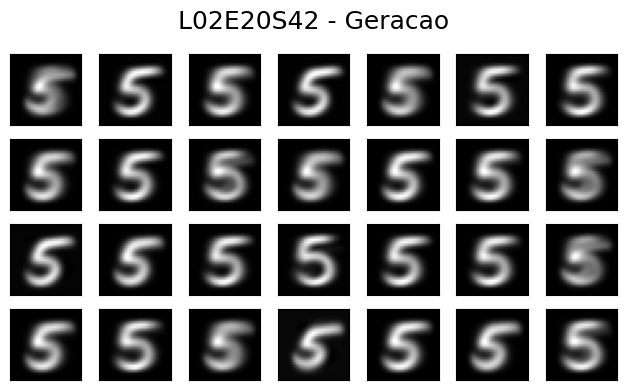

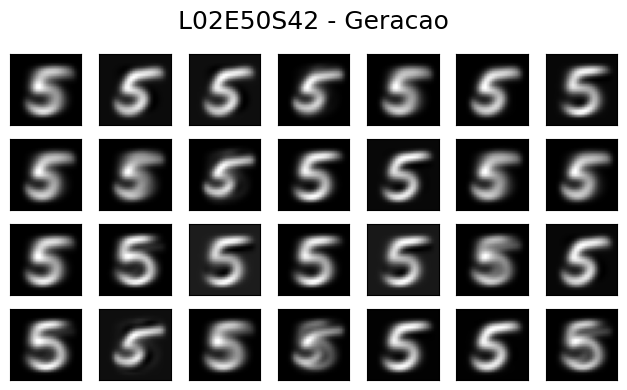

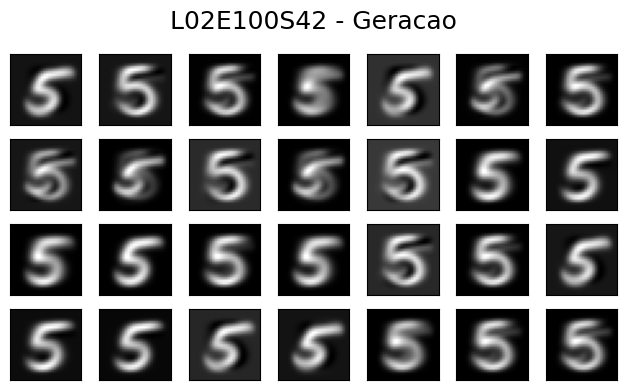

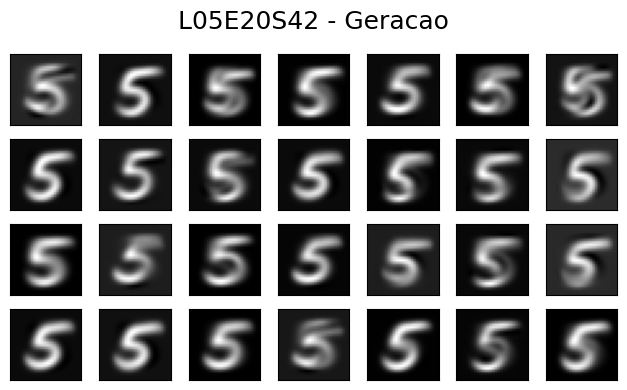

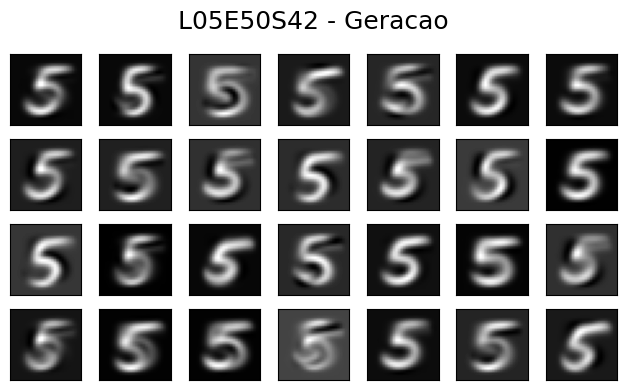

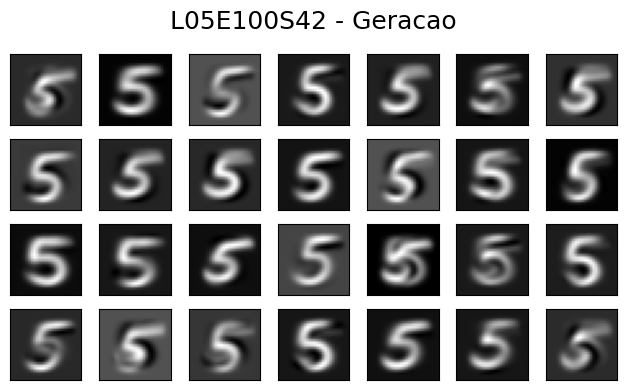

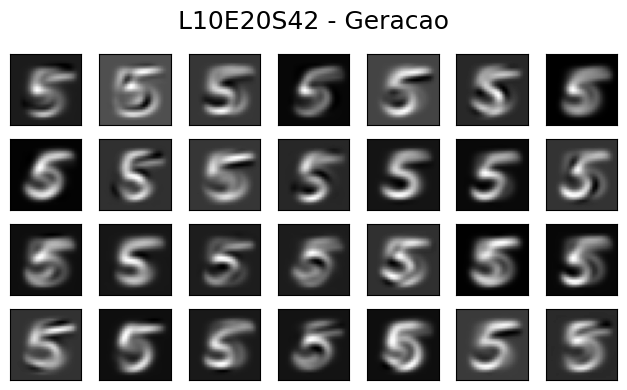

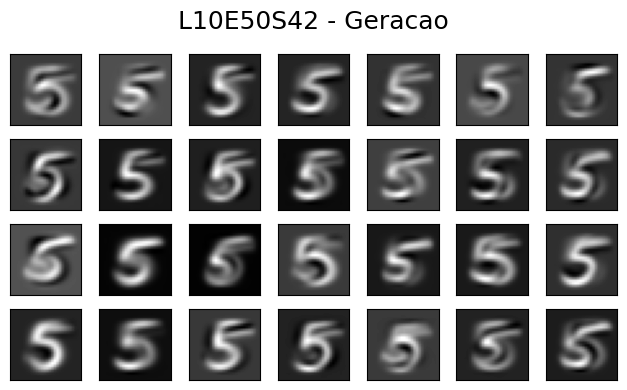

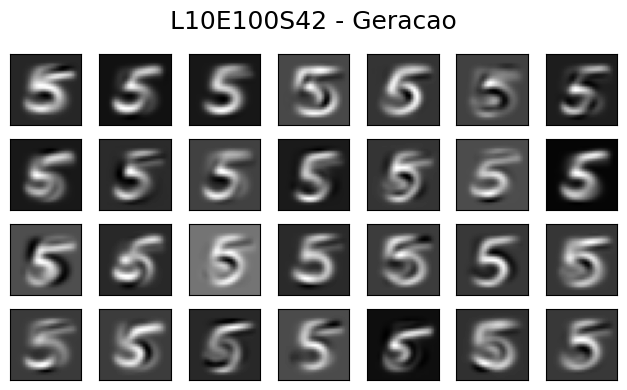

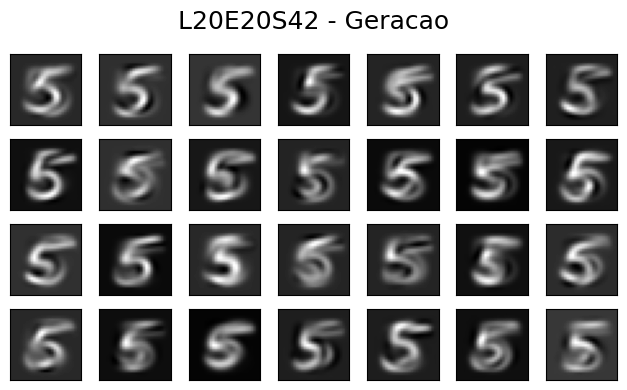

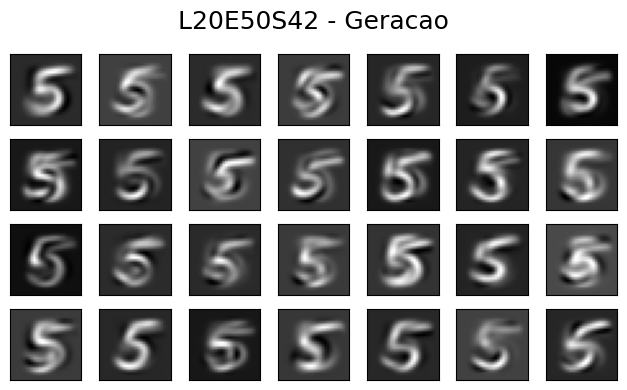

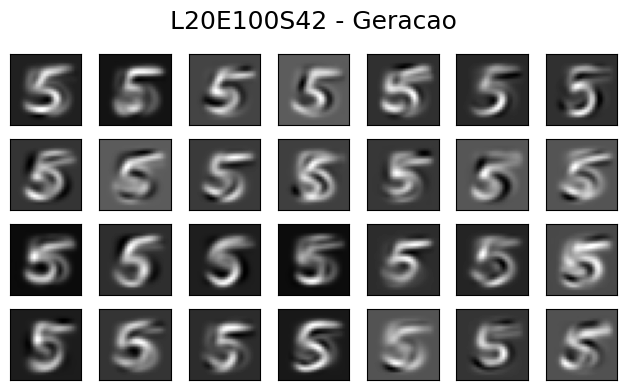

In [74]:
# Geracao
for model in models:
  plot_digits(model.get_samples(size=28), f'{model.code} - Geracao')

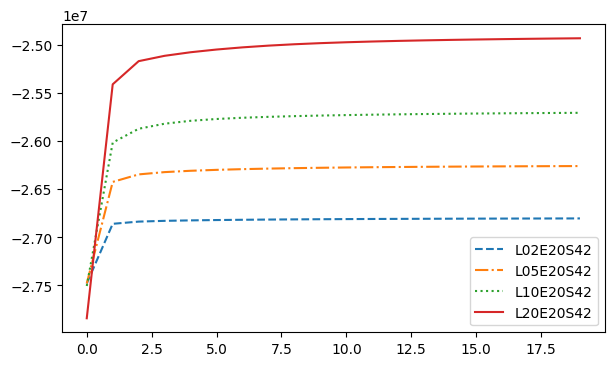

In [132]:
# 20 Epochs
plt.figure(figsize=(7, 4))
plt.plot(models[0].likelihoods, label=models[0].code, ls='--')
plt.plot(models[3].likelihoods, label=models[3].code, ls='-.')
plt.plot(models[6].likelihoods, label=models[6].code, ls=':')
plt.plot(models[9].likelihoods, label=models[9].code, ls='-')
_ = plt.legend()

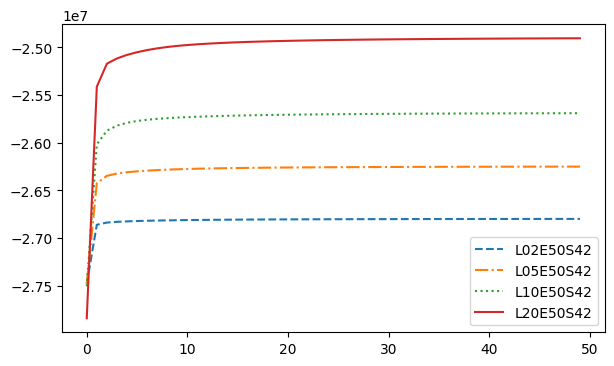

In [133]:
# 50 Epochs
plt.figure(figsize=(7, 4))
plt.plot(models[1].likelihoods, label=models[1].code, ls='--')
plt.plot(models[4].likelihoods, label=models[4].code, ls='-.')
plt.plot(models[7].likelihoods, label=models[7].code, ls=':')
plt.plot(models[10].likelihoods, label=models[10].code, ls='-')
_ = plt.legend()

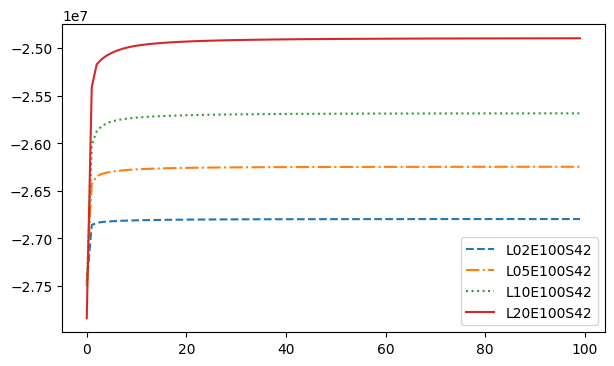

In [134]:
# 100 Epochs
plt.figure(figsize=(7, 4))
plt.plot(models[2].likelihoods, label=models[2].code, ls='--')
plt.plot(models[5].likelihoods, label=models[5].code, ls='-.')
plt.plot(models[8].likelihoods, label=models[8].code, ls=':')
plt.plot(models[11].likelihoods, label=models[11].code, ls='-')
_ = plt.legend()

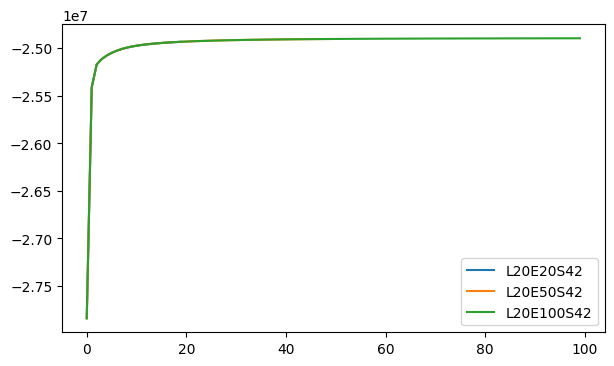

In [135]:
# 100 Epochs
plt.figure(figsize=(7, 4))
plt.plot(models[9].likelihoods, label=models[9].code)
plt.plot(models[10].likelihoods, label=models[10].code)
plt.plot(models[11].likelihoods, label=models[11].code)
_ = plt.legend()

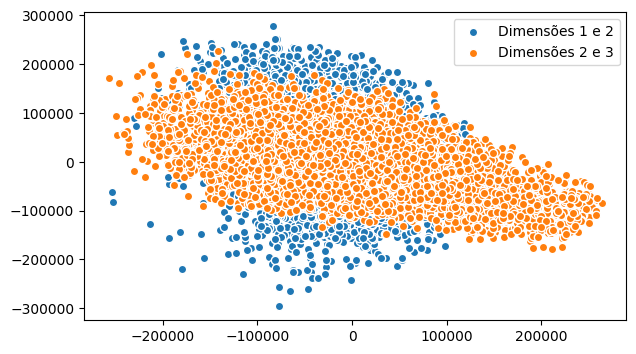

In [139]:
# Scatter
data = np.dot(X - models[9].mu, models[9].W) # Possivelmente a matriz está rotacionada

plt.figure(figsize=(7, 4))
plt.scatter(data[:, 0], data[:, 1], linewidths=1, edgecolors='w', label='Dimensões 1 e 2')
plt.scatter(data[:, 2], data[:, 3], linewidths=1, edgecolors='w', label="Dimensões 2 e 3")
_ = plt.legend()

## Inferência Variacional

In [147]:
# Não pesquisei se esta seria a tradução correta
class UnivariateGaussianVariacionalInference:
  #
  def __init__(self, mu=0, kappa=1, a=2, b=2, epochs=50, tolerance=10**-3):
    self.mu0 = mu           # Gaussian
    self.kappa0 = kappa     # Gaussian
    self.a0 = a             # Gamma
    self.b0 = b             # Gamma
    
    #
    self.epochs = epochs
    self.tolerance = tolerance
    
  #
  def fit(self, X, verbose=False):
    N = X.shape[0] # Show have only one dimension
    
    # Kinda destructuring
    mu0 = self.mu0
    kappa0 = self.kappa0
    a0 = self.a0
    b0 = self.b0
    
    # Initial values (hiding N index)
    kappa = np.inf
    b = b0
    
    # Optimal values (hiding N index)
    mu = (kappa0 * mu0 + np.sum(X)) / (kappa0 + N)
    a = a0 + (N + 1) * 0.5
    
    # Stop criteria
    e = 0
    diff = np.inf
    
    while e < self.epochs and diff > self.tolerance:
      diff = b # Just for holding b's value
      
      #
      kappa = (kappa0 + N) * (a / b)
      b = b0 + kappa0 * 0.5 * (kappa**-1 + (mu - mu0)**2) + 0.5 * np.sum(kappa**-1 + (X - mu)**2)
      
      # Stop updates
      diff = np.absolute(diff - b) # Nem precisa de numpy :-)
      e += 1
      
    if verbose:
      print(f'Stop e → {e}, tolerance → {diff:.4f} ≤ {self.tolerance:.4}')
      print(f'NORMAL: mu → {mu}, kappa → {kappa}')
      print(f'GAMMA a → {a}, b → {b}')
      
    # Final values
    self.mu = mu
    self.kappa = kappa
    self.a = a
    self.b = b
    
    # Defining posteriors
    self.norm  = norm(loc=mu, scale=kappa**-1) # Univariate
    self.gamma = gamma(a=a, scale=b)
    
    #
    return self
  
  #
  def predict(self, X, dist='norm'):
    if dist == 'norm':
      return self.norm.pdf(X)
    elif dist == 'gamma':
      return self.gamma.pdf(X)
  
    return None
  
  def plot(self, title=None):
    # Plot dists
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig.tight_layout()

    #
    qmu_x = np.linspace(self.mu - (3 * self.kappa**-1), self.mu + (3 * self.kappa**-1), 500)
    qmu_hat = self.predict(qmu_x)

    axs[0].plot(qmu_x, qmu_hat, label=r'Distribuição de $q(\mu)$')
    axs[0].set_title(r'Posterior de $\mu$')
    _ = axs[0].legend()

    #
    qtau_x = np.linspace(0, self.gamma.mean() + self.gamma.var() * 0.3, 500)
    qtau_hat = self.predict(qtau_x, dist='gamma')

    axs[1].plot(qtau_x, qtau_hat, label=r'Distribuição de $q(\tau)$')
    axs[1].set_title(r'Posterior de $\tau$')
    _ = axs[1].legend()
    
    #
    if title is not None:
      fig.suptitle(title)
      fig.subplots_adjust(top=0.85)


#### Carregamento dos dados


In [148]:
# Data
X = np.genfromtxt('./files/gaussian_1d.csv', delimiter=',')
X.shape

(500,)

#### Training & Plotting

Stop e → 5, tolerance → 0.0001 ≤ 0.001
NORMAL: mu → 1.6449303006811198, kappa → 10.53466283092682
GAMMA a → 7.5, b → 7.83139753929564


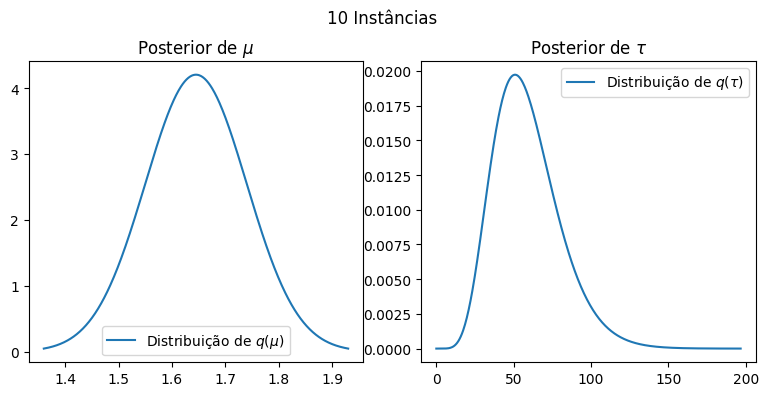

In [149]:
# 10
ugvinf10 = UnivariateGaussianVariacionalInference()
ugvinf10.fit(X[:10], verbose=True).plot('10 Instâncias')

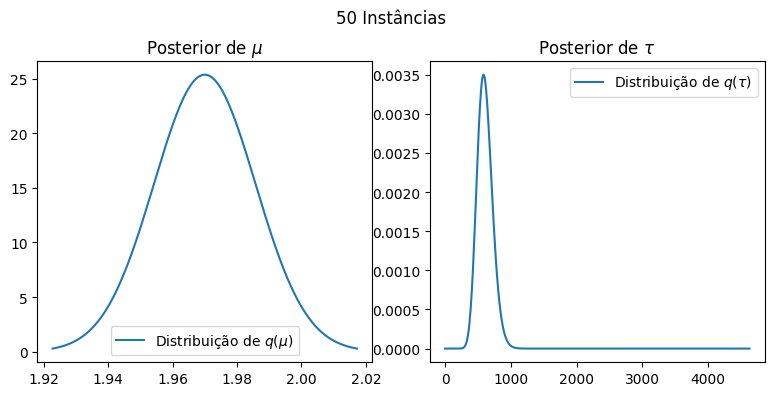

In [150]:
# 50
ugvinf50 = UnivariateGaussianVariacionalInference()
ugvinf50.fit(X[:50]).plot('50 Instâncias')

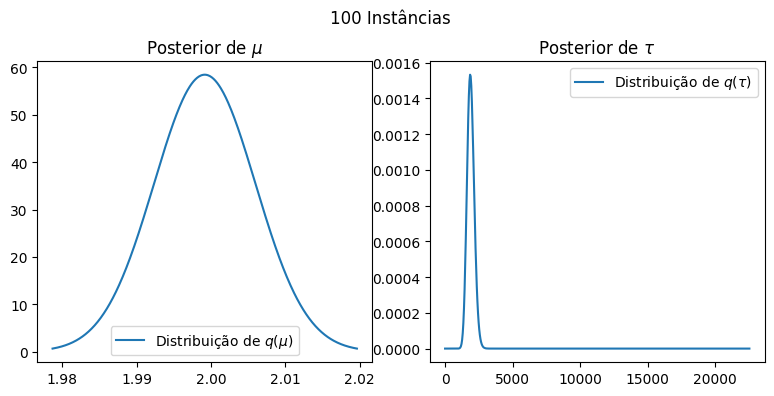

In [151]:
# 100
ugvinf100 = UnivariateGaussianVariacionalInference()
ugvinf100.fit(X[:100]).plot('100 Instâncias')

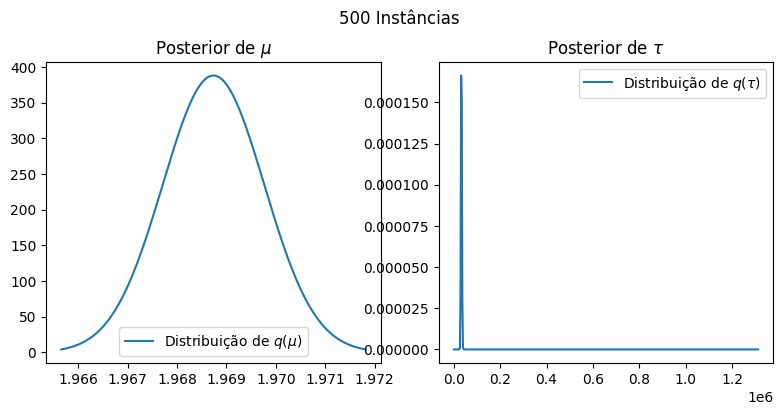

In [152]:
# 500
ugvinf500 = UnivariateGaussianVariacionalInference()
ugvinf500.fit(X[:500]).plot('500 Instâncias')